In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import random
from tqdm import tqdm
import os

In [2]:
# 데이터 경로 설정
DATA_DIR = "../data/raw"
TRAIN_META_PATH = os.path.join(DATA_DIR, "train-metadata.csv")
TRAIN_IMG_DIR = os.path.join(DATA_DIR, "train-image")
TEST_META_PATH = os.path.join(DATA_DIR, "test-metadata.csv")

In [3]:
# 데이터 로드
train_df = pd.read_csv(TRAIN_META_PATH)
test_df = pd.read_csv(TEST_META_PATH)

print("Train Shape:", train_df.shape)
print("Test Shape:", test_df.shape)
display(train_df.head())
display(test_df.head())

/var/folders/fv/jz45s4dx7tv0pdm4xflxn8qw0000gn/T/ipykernel_80186/4105410627.py:2: DtypeWarning: Columns (51,52) have mixed types. Specify dtype option on import or set low_memory=False.
  train_df = pd.read_csv(TRAIN_META_PATH)


Train Shape: (401059, 55)
Test Shape: (3, 44)


,isic_id,target,patient_id,age_approx,sex,anatom_site_general,clin_size_long_diam_mm,image_type,tbp_tile_type,tbp_lv_A,...,lesion_id,iddx_full,iddx_1,iddx_2,iddx_3,iddx_4,iddx_5,mel_mitotic_index,mel_thick_mm,tbp_lv_dnn_lesion_confidence
0,ISIC_0015670,0,IP_1235828,60.0,male,lower extremity,3.04,TBP tile: close-up,3D: white,20.244422,...,NaN,Benign,Benign,NaN,NaN,NaN,NaN,NaN,NaN,97.517282
1,ISIC_0015845,0,IP_8170065,60.0,male,head/neck,1.10,TBP tile: close-up,3D: white,31.712570,...,IL_6727506,Benign,Benign,NaN,NaN,NaN,NaN,NaN,NaN,3.141455
2,ISIC_0015864,0,IP_6724798,60.0,male,posterior torso,3.40,TBP tile: close-up,3D: XP,22.575830,...,NaN,Benign,Benign,NaN,NaN,NaN,NaN,NaN,NaN,99.804040
3,ISIC_0015902,0,IP_4111386,65.0,male,anterior torso,3.22,TBP tile: close-up,3D: XP,14.242329,...,NaN,Benign,Benign,NaN,NaN,NaN,NaN,NaN,NaN,99.989998
4,ISIC_0024200,0,IP_8313778,55.0,male,anterior torso,2.73,TBP tile: close-up,3D: white,24.725520,...,NaN,Benign,Benign,NaN,NaN,NaN,NaN,NaN,NaN,70.442510


,isic_id,patient_id,age_approx,sex,anatom_site_general,clin_size_long_diam_mm,image_type,tbp_tile_type,tbp_lv_A,tbp_lv_Aext,...,tbp_lv_radial_color_std_max,tbp_lv_stdL,tbp_lv_stdLExt,tbp_lv_symm_2axis,tbp_lv_symm_2axis_angle,tbp_lv_x,tbp_lv_y,tbp_lv_z,attribution,copyright_license
0,ISIC_0015657,IP_6074337,45.0,male,posterior torso,2.70,TBP tile: close-up,3D: XP,22.80433,20.007270,...,0.304827,1.281532,2.299935,0.479339,20,-155.06510,1511.222000,113.980100,Memorial Sloan Kettering Cancer Center,CC-BY
1,ISIC_0015729,IP_1664139,35.0,female,lower extremity,2.52,TBP tile: close-up,3D: XP,16.64867,9.657964,...,0.000000,1.271940,2.011223,0.426230,25,-112.36924,629.535889,-15.019287,"Frazer Institute, The University of Queensland...",CC-BY
2,ISIC_0015740,IP_7142616,65.0,male,posterior torso,3.16,TBP tile: close-up,3D: XP,24.25384,19.937380,...,0.230742,1.080308,2.705857,0.366071,110,-84.29282,1303.978000,-28.576050,FNQH Cairns,CC-BY


In [5]:
# 기본 정보 탐색
print("Train info:")
train_df.info()

print("\nMissing Values:")
missing = train_df.isnull().mean().sort_values(ascending=False)
print(missing[missing > 0])

print("\nClass Distribution:")
print(train_df['target'].value_counts(normalize=True))

Train info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 401059 entries, 0 to 401058
Data columns (total 55 columns):
 #   Column                        Non-Null Count   Dtype  
---  ------                        --------------   -----  
 0   isic_id                       401059 non-null  object 
 1   target                        401059 non-null  int64  
 2   patient_id                    401059 non-null  object 
 3   age_approx                    398261 non-null  float64
 4   sex                           389542 non-null  object 
 5   anatom_site_general           395303 non-null  object 
 6   clin_size_long_diam_mm        401059 non-null  float64
 7   image_type                    401059 non-null  object 
 8   tbp_tile_type                 401059 non-null  object 
 9   tbp_lv_A                      401059 non-null  float64
 10  tbp_lv_Aext                   401059 non-null  float64
 11  tbp_lv_B                      401059 non-null  float64
 12  tbp_lv_Bext                   40

환자별 병변 개수 (평균): 384.8934740882917


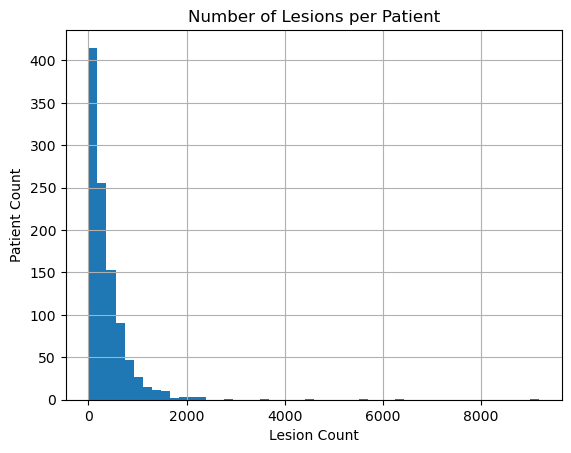

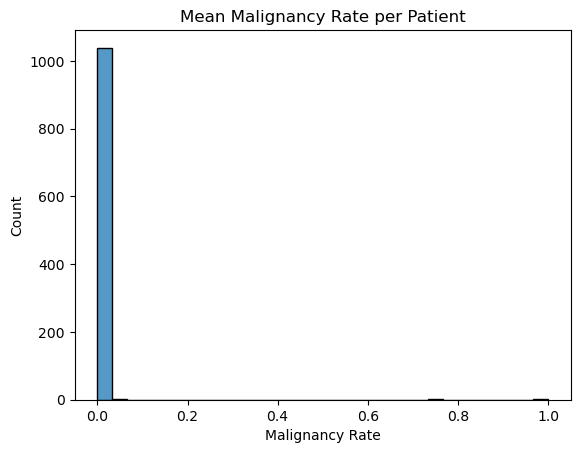

In [6]:
# 환자 단위 병변 탐색
lesion_per_patient = train_df.groupby('patient_id')['isic_id'].count()
print("환자별 병변 개수 (평균):", lesion_per_patient.mean())

lesion_per_patient.hist(bins=50)
plt.title("Number of Lesions per Patient")
plt.xlabel("Lesion Count")
plt.ylabel("Patient Count")
plt.show()

# 악성 비율 높은 환자 비율 확인
malignant_per_patient = train_df.groupby('patient_id')['target'].mean()
sns.histplot(malignant_per_patient, bins=30, kde=False)
plt.title("Mean Malignancy Rate per Patient")
plt.xlabel("Malignancy Rate")
plt.show()

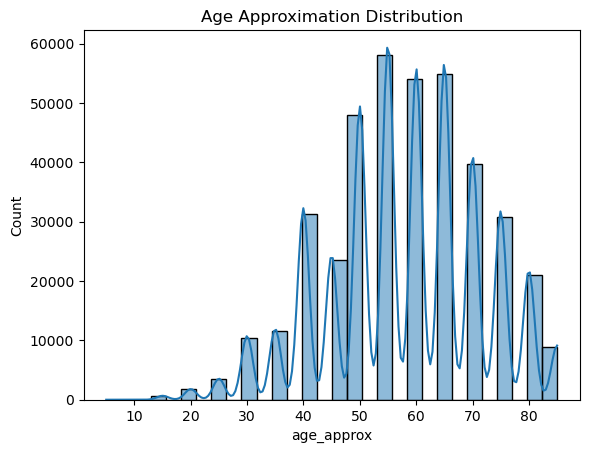

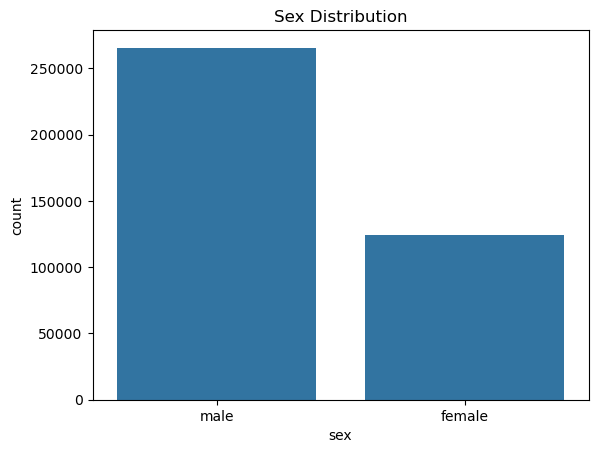

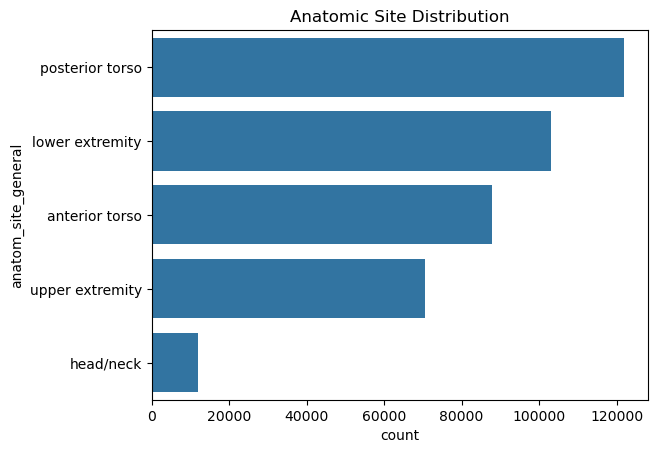

In [7]:
# 주요 변수 탐색
# 나이 분포
sns.histplot(train_df['age_approx'], bins=30, kde=True)
plt.title("Age Approximation Distribution")
plt.show()

# 성별 분포
sns.countplot(x='sex', data=train_df)
plt.title("Sex Distribution")
plt.show()

# 병변 위치
sns.countplot(y='anatom_site_general', data=train_df, order=train_df['anatom_site_general'].value_counts().index)
plt.title("Anatomic Site Distribution")
plt.show()


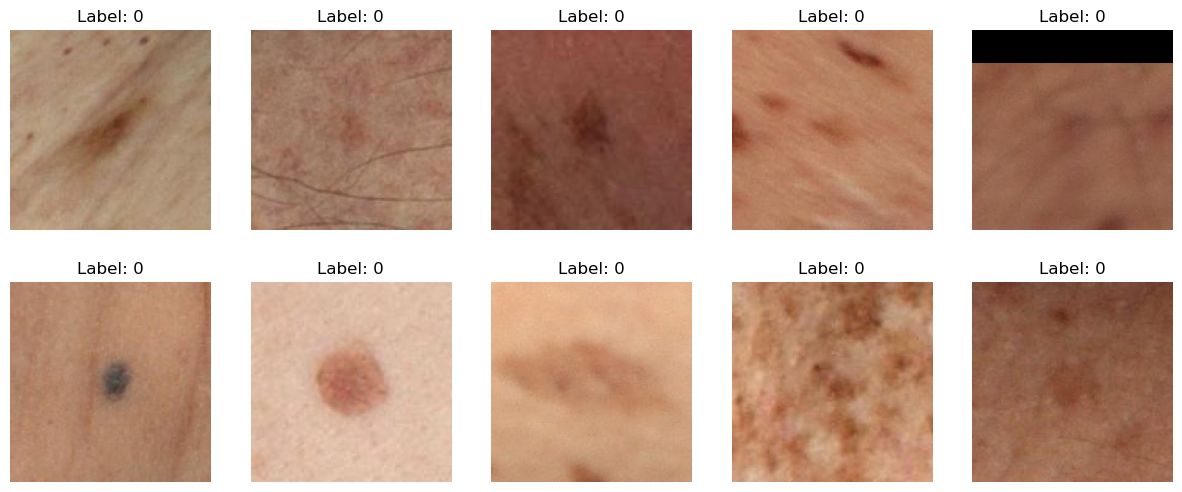

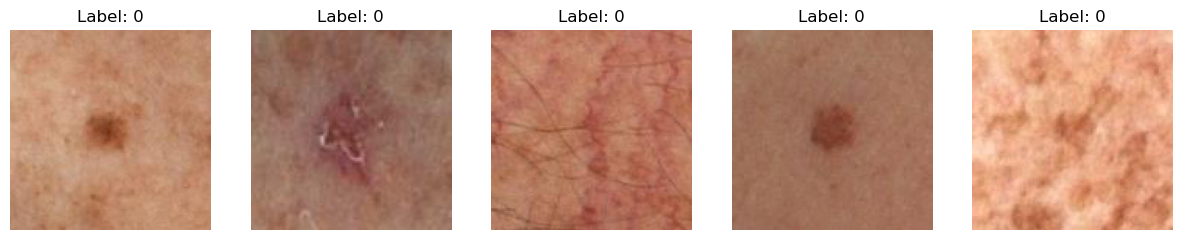

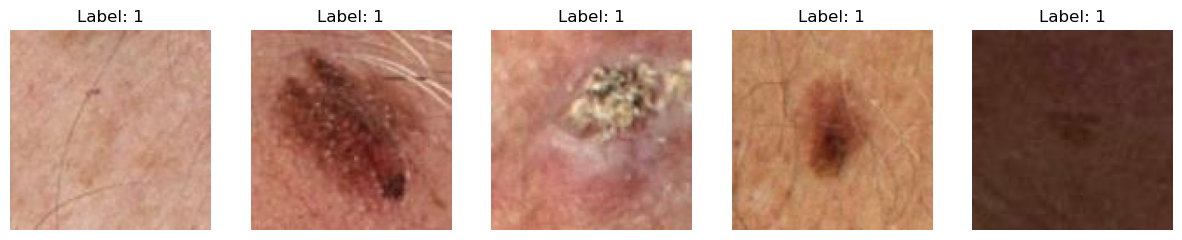

In [12]:
from PIL import Image
import io
import h5py
HDF5_PATH = os.path.join(DATA_DIR, "train-image.hdf5")

# HDF5에서 이미지 로드 함수
def load_image_from_hdf5(img_id):
    with h5py.File(HDF5_PATH, "r") as f:
        # bytes 데이터 읽기
        img_bytes = f[img_id][()]
        # BytesIO로 변환 후 PIL로 열기
        img = Image.open(io.BytesIO(img_bytes))
        # RGB 배열로 변환
        img = img.convert("RGB")
        img_array = np.array(img)
    return img_array

# 이미지 시각화 함수 (HDF5)
def show_images_hdf5(image_ids, labels, n_rows=2, n_cols=5):
    plt.figure(figsize=(15, 6))
    for idx, (img_id, label) in enumerate(zip(image_ids, labels)):
        img = load_image_from_hdf5(img_id)
        plt.subplot(n_rows, n_cols, idx + 1)
        plt.imshow(img)
        plt.title(f"Label: {label}")
        plt.axis('off')
    plt.show()

# 랜덤 이미지 10개 표시
sample = train_df.sample(10)
show_images_hdf5(sample['isic_id'].values, sample['target'].values)

# 악성/양성 비교 이미지
benign_sample = train_df[train_df['target'] == 0].sample(5)
malignant_sample = train_df[train_df['target'] == 1].sample(5)
show_images_hdf5(benign_sample['isic_id'].values, benign_sample['target'].values, n_rows=1, n_cols=5)
show_images_hdf5(malignant_sample['isic_id'].values, malignant_sample['target'].values, n_rows=1, n_cols=5)

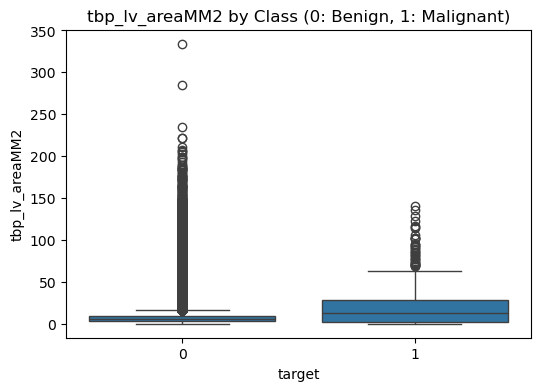

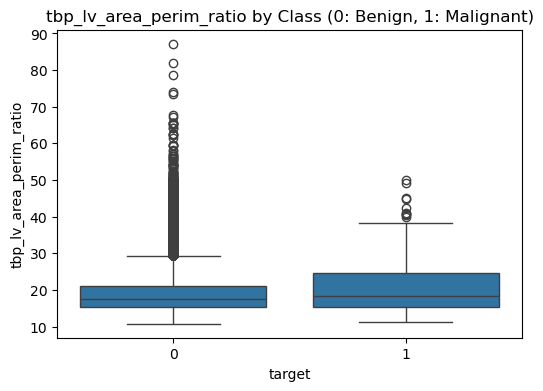

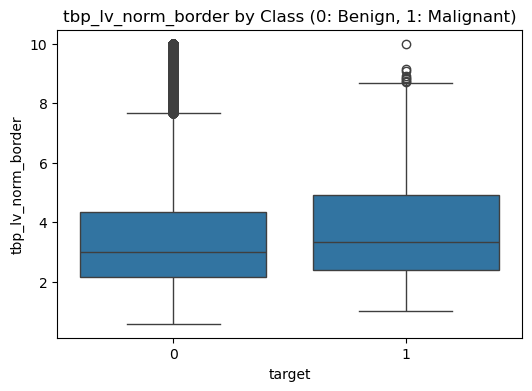

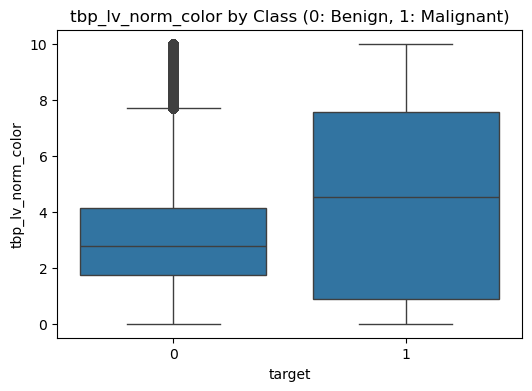

In [13]:
# 주요 병변 특성 시각화
features = ['tbp_lv_areaMM2', 'tbp_lv_area_perim_ratio', 'tbp_lv_norm_border', 'tbp_lv_norm_color']

for feat in features:
    plt.figure(figsize=(6, 4))
    sns.boxplot(x='target', y=feat, data=train_df)
    plt.title(f"{feat} by Class (0: Benign, 1: Malignant)")
    plt.show()